In [6]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from google.cloud import storage
from project_config import GCP_PROJECT_NAME

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

### Configuration

In [8]:
VALIDATION_SITES = ["Ken_Banda", "Sone_Rohtas"]
TILE_SIZE = 110

import albumentations as A
AUGMENTATION_TRAIN = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.CoarseDropout(max_height=32, max_width=32, max_holes=3)
])

EXPERIMENT_DIR = '../out/0725-more-data'
# EXPERIMENT_DIR = '../out/0809-UNetOriginal'

BATCH_SIZE = 256
LR = 3e-2

MODEL_TYPE = 'small'



### Create Rastervision datasets

In [9]:
from torch.utils.data import ConcatDataset

from utils.rastervision_utils import observation_to_scene, scene_to_training_ds, scene_to_validation_ds
from utils.data_management import observation_factory

from project_config import S2_CHANNELS


def is_validation(scene):
    return any(
        [validation_site in scene.id
         for validation_site in VALIDATION_SITES]
    )

def is_training(scene):
    return not is_validation(scene)


all_observations = observation_factory(gcp_client)
all_scenes = list(map(
    lambda observation: observation_to_scene(observation, S2_CHANNELS),
    all_observations
))

training_scenes = filter(is_training, all_scenes)
validation_scenes = filter(is_validation, all_scenes)

training_datasets = list(map(
    lambda scene: scene_to_training_ds(scene, TILE_SIZE, AUGMENTATION_TRAIN),
    training_scenes
))
validation_datasets = list(map(
    lambda scene: scene_to_validation_ds(scene, TILE_SIZE),
    validation_scenes
))
assert len(training_datasets) + len(validation_datasets) == len(all_scenes)

train_dataset_merged = ConcatDataset(training_datasets)
val_dataset_merged = ConcatDataset(validation_datasets)


2023-08-09 17:12:57:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/tmp2ffjnugv/cache/http/storage.googleapis.com/sand_mining/labels/Betwa_Hamirpur_79-81_25-91/bs/Betwa_Hamirpur_79-81_25-91_2022-03-22_bs.tif.
2023-08-09 17:12:57:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/tmp2ffjnugv/cache/http/storage.googleapis.com/sand_mining/labels/Betwa_Hamirpur_79-81_25-91/annotations/Betwa_Hamirpur_79-81_25-91_2022-03-22_annotations.geojson.
2023-08-09 17:12:57:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining/labels/Betwa_Hamirpur_79-81_25-91/bs/Betwa_Hamirpur_79-81_25-91_2022-04-01_bs.tif to /data/tmp/tmp2ffjnugv/cache/http/storage.googleapis.com/sand_mining/labels/Betwa_Hamirpur_79-81_25-91/bs/Betwa_Hamirpur_79-81_25-91_2022-04-01_bs.tif...
2023-08-09 17:12:58:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining/labels/Betwa_Hamirpu

 96%|#########5| 152M/159M [00:05<00:00, 31.1MB/s]

2023-08-09 17:13:20:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining/labels/Sone_Rohtas_84-21_24-91/annotations/Sone_Rohtas_84-21_24-91_2022-03-01_annotations.geojson to /data/tmp/tmp2ffjnugv/cache/http/storage.googleapis.com/sand_mining/labels/Sone_Rohtas_84-21_24-91/annotations/Sone_Rohtas_84-21_24-91_2022-03-01_annotations.geojson...
2023-08-09 17:13:20:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining/labels/Sone_Rohtas_84-21_24-91/bs/Sone_Rohtas_84-21_24-91_2022-03-31_bs.tif to /data/tmp/tmp2ffjnugv/cache/http/storage.googleapis.com/sand_mining/labels/Sone_Rohtas_84-21_24-91/bs/Sone_Rohtas_84-21_24-91_2022-03-31_bs.tif...


 67%|######7   | 104M/155M [00:05<00:02, 21.8MB/s]

2023-08-09 17:13:27:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining/labels/Sone_Rohtas_84-21_24-91/annotations/Sone_Rohtas_84-21_24-91_2022-03-31_annotations.geojson to /data/tmp/tmp2ffjnugv/cache/http/storage.googleapis.com/sand_mining/labels/Sone_Rohtas_84-21_24-91/annotations/Sone_Rohtas_84-21_24-91_2022-03-31_annotations.geojson...
2023-08-09 17:13:28:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining/labels/Sone_Rohtas_84-21_24-91/bs/Sone_Rohtas_84-21_24-91_2022-04-30_bs.tif to /data/tmp/tmp2ffjnugv/cache/http/storage.googleapis.com/sand_mining/labels/Sone_Rohtas_84-21_24-91/bs/Sone_Rohtas_84-21_24-91_2022-04-30_bs.tif...
2023-08-09 17:13:33:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining/labels/Sone_Rohtas_84-21_24-91/annotations/Sone_Rohtas_84-21_24-91_2022-04-30_annotations.geojson to /data/tmp/tmp2ffjnugv/cache/http/s

 98%|#########8| 152M/155M [00:05<00:00, 31.3MB/s]

2023-08-09 17:13:46:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining/labels/Sone_Rohtas_84-21_24-91/annotations/Sone_Rohtas_84-21_24-91_2022-12-16_annotations.geojson to /data/tmp/tmp2ffjnugv/cache/http/storage.googleapis.com/sand_mining/labels/Sone_Rohtas_84-21_24-91/annotations/Sone_Rohtas_84-21_24-91_2022-12-16_annotations.geojson...
2023-08-09 17:13:46:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining/labels/Tawa_Hoshangabad_77-80_22-74/bs/Tawa_Hoshangabad_77-80_22-74_2022-03-02_bs.tif to /data/tmp/tmp2ffjnugv/cache/http/storage.googleapis.com/sand_mining/labels/Tawa_Hoshangabad_77-80_22-74/bs/Tawa_Hoshangabad_77-80_22-74_2022-03-02_bs.tif...
2023-08-09 17:13:47:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining/labels/Tawa_Hoshangabad_77-80_22-74/annotations/Tawa_Hoshangabad_77-80_22-74_2022-03-02_annotations.geojson to /dat

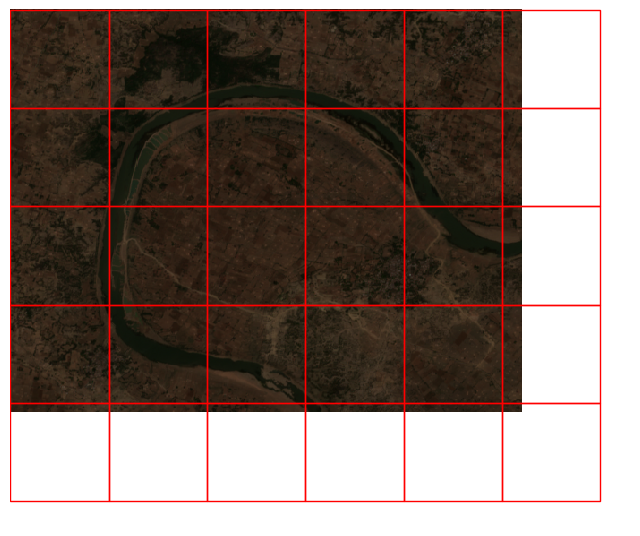

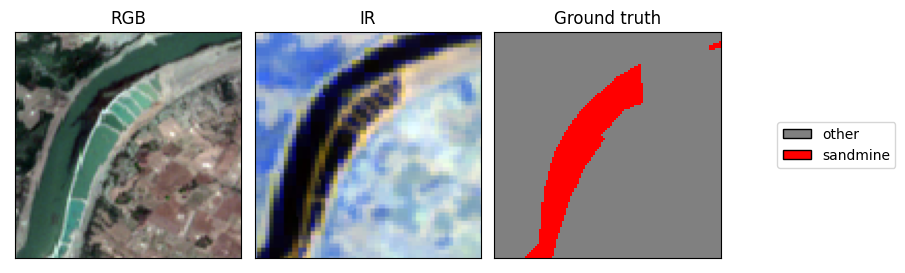

In [10]:
from utils.visualizing import show_windows, show_image_in_dataset
from project_config import DISPLAY_GROUPS, CLASS_CONFIG

ds_to_visualize = validation_datasets[2]
show_windows(
    ds_to_visualize.scene.raster_source[:,:],
    ds_to_visualize.windows
)
show_image_in_dataset(
    ds_to_visualize,
    CLASS_CONFIG,
    DISPLAY_GROUPS,
    idx=7
)

## Sanity check to make sure there are no NaNs in training and validation data

In [11]:
from rastervision.pytorch_learner.dataset.visualizer import SemanticSegmentationVisualizer
import torch

visualizer = SemanticSegmentationVisualizer(
        class_names=CLASS_CONFIG.names,
        class_colors=CLASS_CONFIG.colors,
        channel_display_groups=DISPLAY_GROUPS,
    )


for img in validation_datasets:
    x, _ = visualizer.get_batch(img)
    # count the number of nan values in the image x
    # print(torch.isnan(x).sum())
    assert not torch.isnan(x).any()


for img in training_datasets:
    x, _ = visualizer.get_batch(img)
    # count the number of nan values in the image x
    # print(torch.isnan(x).sum())
    assert not torch.isnan(x).any()

print ('No NaN values in training and validation datasets.')

No NaN values in training and validation datasets.


# Train

In [12]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
# torch.cuda.empty_cache()

In [14]:
from utils.rastervision_utils import construct_semantic_segmentation_learner
from models.unet.unet_small import UNetSmall
from models.unet.unet_original import UNet

_, _, n_channels = training_datasets[0].scene.raster_source.shape
n_classes = 2

if MODEL_TYPE == 'small':
    from models.unet.unet_small import UNetSmall
    model = UNetSmall(n_channels, n_classes)

else:
    from models.unet.unet_original import UNet
    model = UNet(n_channels, n_classes)



learner = construct_semantic_segmentation_learner(
    model=model,
    training_ds=train_dataset_merged,
    validation_ds=val_dataset_merged,
    batch_size=BATCH_SIZE,
    learning_rate=LR,
    # class_loss_weights=[1., 10.],
    experiment_dir=EXPERIMENT_DIR
)
learner.log_data_stats()

2023-08-09 17:14:02:rastervision.pytorch_learner.learner: INFO - train_ds: 9643 items
2023-08-09 17:14:02:rastervision.pytorch_learner.learner: INFO - valid_ds: 3048 items


In [15]:
learner.train(epochs=10)
learner.save_model_bundle()

2023-08-09 17:15:34:rastervision.pytorch_learner.learner: INFO - epoch: 0


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

2023-08-09 17:26:43:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.9633212089538574,
 'avg_precision': 0.9514943957328796,
 'avg_recall': 0.9754457473754883,
 'epoch': 0,
 'other_f1': 0.9875702857971191,
 'other_precision': 0.9754457473754883,
 'other_recall': 1.0,
 'sandmine_f1': 0.0,
 'sandmine_precision': 0.0,
 'sandmine_recall': 0.0,
 'train_loss': 0.000609350565445815,
 'train_time': '0:08:19.435093',
 'val_loss': 0.0005041395779699087,
 'valid_time': '0:02:49.811082'}


### Predict on validation locations 
And export visualizations to tensorboard

# Tensorboard

To activate tensorboard, run the following command in the terminal:
`conda activate rastervision` (or whatever your conda environment is called)

`tensorboard --logdir sandmining-watch/out/<EXPERIMENT_DIR>` (make sure it's relative to your current path in the terminal)

You will also need to port-forward; on your local machine, run:

`ssh -N -f -L localhost:6006:localhost:6006 <USERNAME>@fati.ischool.berkeley.edu`

Note: this is not needed if you're running from within VS Code- it should automatically give you the option to open tensorboard in the browser.